# Factores de riesgo
Este proyecto se corresponde al trabajo final del curso de Data Science dictado por la Fundación YPF en el año 2024.

## Objetivos del proyecto
Desarrollar un modelo predictivo para identificar individuos con alto riesgo de desarrollar enfermedades crónicas (como hipertensión, diabetes, colesterol alto) basándose en sus comportamientos y condiciones de vida.

## Setup de archivos

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns

from utils.funcions import *
from utils.codificaciones import *

### Lectura de datasets

In [2]:
# Conecto drive
from google.colab import drive
drive.mount('/content/drive')

# Leo el archivo
friesgo_2018 = pd.read_csv('/content/drive/MyDrive/INGENIAS/TrabajoP/bd/friesgo2018.txt', delimiter = '|')

ModuleNotFoundError: No module named 'google'

In [6]:
## Leo el archivo localmente
friesgo_2018 = pd.read_csv('datasets/friesgo2018.txt', delimiter = '|')

## Analizando el dataset (raw)

In [ ]:
# Determino filas y columnas
friesgo_2018.shape

(29224, 287)

In [ ]:
# Obtengo las 5 primeras filas del dataset
friesgo_2018.head()

,id,cod_provincia,region,tamanio_aglomerado,aglomerado,localidades_150,submuestra,bhcv01,bhcv02,bhcv03,...,glucemia_elevada,prevalencia_glucemia_elevada_combinada,findrisc,bimq06,bimq06_01,colesterol_elevado,prevalencia_colesterol_combinada,wf1p,wf2p,wf3p
0,1128639,2,1,1,1,1,1,3,2,1,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2378,4464,0
1,1709939,2,1,1,1,1,0,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3588,0,0
2,6874130,2,1,1,1,1,0,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2740,0,0
3,10319375,2,1,1,1,1,1,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493,0,0
4,11140857,2,1,1,1,1,0,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0,0


##  Evaluacion de columnas del dataset

Vamos a agrupar las columnas por temática, manteniendo ciertas columnas que permiten la identificacion del registro (como el id) y aquellas necesarias para realizar analisis, tales como variables demograficas.
Por cada temática:

*   Visualizo las primeras filas
*   Renombro columnas y evaluo los nulos
*   Calculo de porcentaje de faltantes por columna

### Busqueda y localizacion de bloques tematicos

In [ ]:
#Busco el indice de una columna para dividir los bloques tematicos
friesgo_2018.columns.get_loc('cobertura_salud')

65

In [ ]:
hipertension = friesgo_2018.iloc[:,140:159]
#hipertension.head(20)
calcular_nulos_y_porcentaje(hipertension)

,Nulos,Porcentaje
biha01,0,0.000000
biha02,2082,7.124281
biha03,0,0.000000
biha04,18791,64.299891
biha05_01,23511,80.450999
biha05_02,23511,80.450999
biha06,24009,82.155078
biha06_99,29201,99.921298
biha07,23986,82.076376
biha08,23986,82.076376


In [ ]:
pesocorporal = friesgo_2018.iloc[:,160:168]
#pesocorporal.head(20)
calcular_nulos_y_porcentaje(pesocorporal)

,Nulos,Porcentaje
bipc01,0,0.000000
bipc02,19984,68.382152
bipc03,5401,18.481385
bipc04,1011,3.459485
bipc04_99,28213,96.540515
bipc05,1676,5.735012
bipc05_99,27548,94.264988
imc,2229,7.627293


In [ ]:
alimentacion = friesgo_2018.iloc[:,169:186]
#alimentacion.head(20)
calcular_nulos_y_porcentaje(alimentacion)

,Nulos,Porcentaje
bial01,0,0.000000
bial02,0,0.000000
bial03,571,1.953874
bial03_99,28653,98.046126
bial04,3018,10.327128
bial04_99,28774,98.460170
bial05,287,0.982070
bial05_99,28937,99.017930
bial06,1164,3.983028
bial06_99,28965,99.113742


### Tabaquismo
Este bloque contiene respuestas sobre consumo de tabaco. Edades de consumo, tipos de tabaco consumidos, periodicidad, lugares donde podria existir tabaquismo pasivo y la inluencia de la propaganda en las decisiones sobre fumar o dejar.

In [27]:
# Creo el DataFrame raw para tabaquismo
# Selecciono la columna 0 - correspondiente a la columna id - y el rango de preguntas para tabaquismo
tabaquismo_raw = pd.DataFrame(friesgo_2018.iloc[:, [0] + list(range(98, 133))]).copy()

In [28]:
# Calculo nueva columna cant_tipos_tabaco
# Subconjunto de columnas donde queremos contar los 1s
columnas_subconjunto = ['bita09_01', 'bita09_02', 'bita09_03', 'bita09_04', 'bita09_05', 'bita09_06']

# Llamar a la función con el subconjunto de columnas
tabaquismo_raw.loc[:, 'cant_tipos_tabaco'] = calcular_tipos_tabaco(tabaquismo_raw, columnas_subconjunto)

In [29]:
# Renombro columnas
tabaquismo_raw.rename(columns = {
    'bita01':               'es_fumador',                                       # var categorica
    'bita02':               'edad_fuma_primera_vez',                            # var numerica discreta
    'bita02_99':            'edad_fuma_primera_vez_ns_nc',                      # var numerica discreta
    'bita03':               'fumado_100_cigarrillos',                           # var categorica
    'bita04':               'periodicidad_fumador',                             # var ordinal
    'bita04_01':            'es_cigarrillo_armado',                             # var categorica
    'bita04_02':            'es_cigarrillo_paquete',                            # var categorica
    'bita05':               'marca_cigarrillos',                                # var categorica
    'bita06_a':             'tipo_paquete_comprado',                            # var categorica
    'bita06_b':             'cant_cigarrillos_comprados',                       # var numerica discreta
    'bita06_b_99':          'cant_cigarrillos_comprados_ns_nc',                 # var numerica discreta
    'bita06_c':             'cigarrillos_sabor',                                # var categorica
    'bita06_d':             'cigarrillos_tipo_capsula',                         # var categorica
    'bita07':               'dinero_pagado_ultima_compra_cigarrillos',          # var numerica discreta
    'bita07_99':            'dinero_pagado_ultima_compra_cigarrillos_ns_nc',    # var categorica
    'bita08':               'intento_dejar_fumar',                              # var categorica
    'bita09_01':            'es_fumador_cigarro_habano',                        # var categorica
    'bita09_02':            'es_fumador_cigarritos',                            # var categorica
    'bita09_03':            'es_fumador_pipa_comun',                            # var categorica
    'bita09_04':            'es_fumador_pipa_agua',                             # var categorica
    'bita09_05':            'es_fumador_tabaco_masticar',                       # var categorica
    'bita09_06':            'es_fumador_cigarrillo_electronico',                # var categorica
    'bita10_01':            'hubo_fumadores_casa',                              # var categorica
    'bita10_02':            'hubo_fumadores_trabajo',                           # var categorica
    'bita10_03':            'hubo_fumadores_escuela',                           # var categorica
    'bita10_04':            'hubo_fumadores_restaurant',                        # var categorica
    'bita10_05':            'hubo_fumadores_hospital',                          # var categorica
    'bita10_06':            'hubo_fumadores_otros_lugares',                     # var categorica
    'bita11':               'publicidad_comercios',                             # var categorica
    'bita12':               'publicidad_email',                                 # var categorica
    'bita13':               'suscripcion_cigarrera',                            # var categorica
    'bita14':               'vio_propaganda_riesgo_fumar',                      # var categorica
    'bita15':               'propaganda_piensa_dejar_fumar',                    # var categorica
    'bita16':               'acuerdo_impuesto_tabaco',                           # var categorica
    'consumo_tabaco_100':   'condicion_fumador'
}, inplace = True)

In [30]:
# Selecciono las columnas
tabaquismo = tabaquismo_raw[[
    'id', 
    'condicion_fumador', 
    'edad_fuma_primera_vez', 
    'fumado_100_cigarrillos',
    'periodicidad_fumador',
    'cant_tipos_tabaco'
    ]]

In [ ]:
# Visualizo las primeras 20 filas
tabaquismo.head(20)

In [ ]:
# Determinar tipos de datos de las columnas
tabaquismo.dtypes

In [ ]:
# Visualizo nulos y porcentaje
calcular_nulos_y_porcentaje(tabaquismo)

In [ ]:
# Visualizo cada valor en las variables
calcular_valores_columna(tabaquismo)

### Diabetes
Este bloque contiene respuestas sobre diagnostico, tratamiento y antecedentes sobre diabetes.

In [36]:
# Creo el DataFrame raw para diabetes
# Selecciono la columna 0 - correspondiente a la columna id - y el rango de preguntas para diabetes
diabetes_raw = pd.DataFrame(friesgo_2018.iloc[:, [0] + list(range(218, 236))]).copy()

In [37]:
# Creo una nueva columna para diagnostico en cosanguineos
''' Resultados posibles
   bidi06_01  bidi06_02    diagnostico_cosanguineos
0        1.0        1.0        cosanguineo_primario
1        2.0        2.0        sin antecedentes
2        NaN        1.0        cosanguineo_secundario
3        1.0        NaN        cosanguineo_primario
4        2.0        NaN        sin antecedentes
5        NaN        2.0        sin antecedentes
6        1.0        2.0        cosanguineo_primario
7        2.0        1.0        cosanguineo_secundario
8        NaN        NaN        ns/nc
'''
diabetes_raw['diagnostico_cosanguineos'] = np.where(
    diabetes_raw['bidi06_01'] == 1, 'cosanguineo_primario',
    np.where(
        (diabetes_raw['bidi06_01'] != 1) & (diabetes_raw['bidi06_02'] == 1), 'cosanguineo_secundario',
        np.where(
            (diabetes_raw['bidi06_01'] == 2) | (diabetes_raw['bidi06_02'] == 2), 'sin antecedentes',
            'ns/nc'
        )
    )
)

In [53]:
# Renombro columnas
diabetes_raw.rename(columns = {
    'bidi01':               'es_diabetico',                                     # var categorica
    'bidi02':               'es_diabetes_gestacional',                          # var categorica
    'bidi03':               'en_tratamiento_diabetes',                          # var categorica
    'bidi04_01':            'en_tratamiento_diabetes_insulina',                 # var categorica
    'bidi04_02':            'en_tratamiento_diabetes_otros',                    # var categorica
    'bidi04_03':            'en_tratamiento_diabetes_medicamentos',             # var categorica
    'bidi05':               'es_insulinodependiente',                           # var categorica
    'bidi06_01':            'diagnostico_diabetes_cosanguineo_primario',        # var categorica
    'bidi06_02':            'diagnostico_diabetes_cosanguineo_secundario',      # var categorica
    'bidi07':               'ultima_medicion_glucemia',                         # var categorica
    'bidi08':               'controla_diabetes',                                # var categorica
    'bidi09':               'lugar_control_diabetes',                           # var categorica
    'bidi10':               'atencion_diabetes_mismo_profesional',              # var categorica
    'bidi11':               'atencion_diabetes_hc',                             # var categorica
    'bidi12':               'revision_pies',                                    # var categorica
    'bidi13':               'revision_pupilas',                                 # var categorica
    'bidi14':               'educado_control_diabetes',                         # var categorica
}, inplace = True)

In [40]:
# Selecciono las columnas
diabetes = diabetes_raw[[
    'id', 
    'es_diabetico', 
    'es_diabetes_gestacional', 
    'en_tratamiento_diabetes',
    'diagnostico_cosanguineos',
    'ultima_medicion_glucemia'
    ]]

In [41]:
# Visualizo las primeras 20 filas
diabetes.head(20)

,id,es_diabetico,es_diabetes_gestacional,en_tratamiento_diabetes,diagnostico_cosanguineos,ultima_medicion_glucemia
0,1128639,2,NaN,NaN,sin antecedentes,2
1,1709939,2,NaN,NaN,sin antecedentes,1
2,6874130,2,NaN,NaN,sin antecedentes,2
3,10319375,2,NaN,NaN,cosanguineo_secundario,2
4,11140857,2,NaN,NaN,sin antecedentes,1
5,12665714,2,NaN,NaN,sin antecedentes,1
6,13089112,99,NaN,NaN,sin antecedentes,1
7,19254804,2,NaN,NaN,sin antecedentes,1
8,19959160,2,NaN,NaN,cosanguineo_secundario,3
9,21544403,2,NaN,NaN,sin antecedentes,1


In [42]:
# Determinar tipos de datos de las columnas
diabetes.dtypes

id                            int64
es_diabetico                  int64
es_diabetes_gestacional     float64
en_tratamiento_diabetes     float64
diagnostico_cosanguineos     object
ultima_medicion_glucemia      int64
dtype: object

In [43]:
# Visualizo nulos y porcentaje
calcular_nulos_y_porcentaje(diabetes)

,Nulos,Porcentaje
id,0,0.000000
es_diabetico,0,0.000000
es_diabetes_gestacional,26829,91.804681
en_tratamiento_diabetes,25300,86.572680
diagnostico_cosanguineos,0,0.000000
ultima_medicion_glucemia,0,0.000000


In [44]:
# Visualizo cada valor en las variables
calcular_valores_columna(diabetes)

Proporción de valores para la columna id:
id
1128639       0.000034
92473058      0.000034
89558645      0.000034
87658375      0.000034
81765850      0.000034
                ...   
1108816564    0.000034
1108719577    0.000034
1107032378    0.000034
1105257785    0.000034
2134624977    0.000034
Name: proportion, Length: 29224, dtype: float64

Proporción de valores para la columna es_diabetico:
es_diabetico
2     0.861107
1     0.134273
99    0.004619
Name: proportion, dtype: float64

Proporción de valores para la columna es_diabetes_gestacional:
es_diabetes_gestacional
2.0     0.766180
1.0     0.224217
99.0    0.009603
Name: proportion, dtype: float64

Proporción de valores para la columna en_tratamiento_diabetes:
en_tratamiento_diabetes
1.0    0.551988
2.0    0.448012
Name: proportion, dtype: float64

Proporción de valores para la columna diagnostico_cosanguineos:
diagnostico_cosanguineos
sin antecedentes          0.478477
cosanguineo_primario      0.329147
cosanguineo_secundario   

### Mediciones antropometricas
Este bloque contiene respuestas sobre medidas antropometricas de cada sujeto de estudio, tales como peso, altura, contorno de la cintura, presion arterial.

In [46]:
# Creo el DataFrame raw para mediciones antropometricas
# Selecciono la columna 0 - correspondiente a la columna id - y el rango de preguntas para mediciones antropometricas
mediciones_antropometricas_raw = pd.DataFrame(friesgo_2018.iloc[:, [0] + list(range(252, 273))]).copy()

In [51]:
# Renombro columnas
mediciones_antropometricas_raw.rename(columns = {
    'bima01':               'consentimiento_ma',                                # var categorica
    'bima02':               'bebio_cafeina',                                    # var categorica
    'bima03':               'consentimiento_presion',                           # var categorica
    'bima04_01_a':          'primera_medicion_sistolica',                       # var numerica continua
    'bima04_01_b':          'primera_medicion_diastolica',                      # var numerica continua
    'bima04_02_a':          'segunda_medicion_sistolica',                       # var numerica continua
    'bima04_02_b':          'segunda_medicion_diastolica',                      # var numerica continua
    'bima04_03_a':          'tercera_medicion_sistolica',                       # var numerica coninua
    'bima04_03_b':          'primera_medicion_diastolica',                      # var numerica continua
    'ta_elevada':           'presion_arterial_elevada',                         # var categorica
    'bima06':               'consentimiento_altura',                            # var categorica
    'bima07':               'medicion_altura',                                  # var numerica continua
    'bima09':               'consentimiento_peso',                              # var categorica
    'bima10':               'medicion_peso',                                    # var numerica continua
    'bima12':               'consentimiento_cintura',                           # var categorica
    'bima13':               'medicion_cintura',                                 # var numerica continua
    'bima14':               'tipo_medicion_cintura',                            # var categorica
    'imc_bima':             'imc',                                              # var categorica
    'imc_categorias_bima':  'imc_categoria'                                     # var categorica
}, inplace = True)

In [52]:
# Selecciono las columnas
mediciones_antropometricas = mediciones_antropometricas_raw[[
    'id', 
    'bebio_cafeina', 
    'presion_arterial_elevada', 
    'imc_categoria',
    'medicion_cintura'
    ]]

In [54]:
# Visualizo las primeras 20 filas
mediciones_antropometricas.head(20)

,id,bebio_cafeina,presion_arterial_elevada,imc_categoria,medicion_cintura
0,1128639,2.0,1.0,3.0,103.0
1,1709939,NaN,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN,NaN
3,10319375,NaN,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN,NaN
5,12665714,2.0,NaN,1.0,88.0
6,13089112,NaN,NaN,NaN,NaN
7,19254804,2.0,2.0,1.0,75.0
8,19959160,2.0,1.0,1.0,87.0
9,21544403,2.0,NaN,1.0,71.0


In [55]:
# Determinar tipos de datos de las columnas
mediciones_antropometricas.dtypes

id                            int64
bebio_cafeina               float64
presion_arterial_elevada    float64
imc_categoria               float64
medicion_cintura            float64
dtype: object

In [56]:
# Visualizo nulos y porcentaje
calcular_nulos_y_porcentaje(mediciones_antropometricas)

,Nulos,Porcentaje
id,0,0.000000
bebio_cafeina,12647,43.276074
presion_arterial_elevada,12997,44.473720
imc_categoria,12647,43.276074
medicion_cintura,12912,44.182863


In [57]:
# Visualizo cada valor en las variables
calcular_valores_columna(mediciones_antropometricas)

Proporción de valores para la columna id:
id
1128639       0.000034
92473058      0.000034
89558645      0.000034
87658375      0.000034
81765850      0.000034
                ...   
1108816564    0.000034
1108719577    0.000034
1107032378    0.000034
1105257785    0.000034
2134624977    0.000034
Name: proportion, Length: 29224, dtype: float64

Proporción de valores para la columna bebio_cafeina:
bebio_cafeina
2.0    0.988961
1.0    0.011039
Name: proportion, dtype: float64

Proporción de valores para la columna presion_arterial_elevada:
presion_arterial_elevada
2.0    0.600419
1.0    0.399581
Name: proportion, dtype: float64

Proporción de valores para la columna imc_categoria:
imc_categoria
2.0     0.342764
3.0     0.329372
1.0     0.317790
99.0    0.010074
Name: proportion, dtype: float64

Proporción de valores para la columna medicion_cintura:
medicion_cintura
90.0     0.029487
98.0     0.029058
95.0     0.027832
93.0     0.027097
92.0     0.026729
           ...   
170.0    0.0000

### Mediciones bioquimicas
Este bloque contiene respuestas sobre medidas bioquimicas de cada sujeto de estudio, tales como glucemia y colesterol.

In [58]:
# Creo el DataFrame raw para mediciones bioquimicas
# Selecciono la columna 0 - correspondiente a la columna id - y el rango de preguntas para mediciones bioquimicas
mediciones_bioquimicas_raw = pd.DataFrame(friesgo_2018.iloc[:, [0] + list(range(274, 283))]).copy()

In [ ]:
# Renombro columnas
mediciones_bioquimicas_raw.rename(columns = {
    'bimq01':               'consentimiento_bq',                                # var categorica
    'bimq05':               'medicion_glucosa',                                 # var numerica continua
    'bimq05_01':            'medicion_glucosa_no_registrada',                   # var categorica
    'bimq06':               'medicion_colesterol',                              # var numerica continua
    'bimq06_01':            'medicion_colesterol_no_registrada'                 # var categorica                                  # var categorica
}, inplace = True)

In [60]:
# Selecciono las columnas
mediciones_bioquimicas = mediciones_bioquimicas_raw[[
    'id', 
    'glucemia_elevada', 
    'colesterol_elevado'
    ]]

In [61]:
# Visualizo las primeras 20 filas
mediciones_bioquimicas.head(20)

,id,glucemia_elevada,colesterol_elevado
0,1128639,NaN,NaN
1,1709939,NaN,NaN
2,6874130,NaN,NaN
3,10319375,NaN,NaN
4,11140857,NaN,NaN
5,12665714,2.0,NaN
6,13089112,NaN,NaN
7,19254804,NaN,NaN
8,19959160,2.0,2.0
9,21544403,2.0,2.0


In [62]:
# Determinar tipos de datos de las columnas
mediciones_bioquimicas.dtypes

id                      int64
glucemia_elevada      float64
colesterol_elevado    float64
dtype: object

In [63]:
# Visualizo nulos y porcentaje
calcular_nulos_y_porcentaje(mediciones_bioquimicas)

,Nulos,Porcentaje
id,0,0.000000
glucemia_elevada,24036,82.247468
colesterol_elevado,24313,83.195319


In [64]:
# Visualizo cada valor en las variables
calcular_valores_columna(mediciones_bioquimicas)

Proporción de valores para la columna id:
id
1128639       0.000034
92473058      0.000034
89558645      0.000034
87658375      0.000034
81765850      0.000034
                ...   
1108816564    0.000034
1108719577    0.000034
1107032378    0.000034
1105257785    0.000034
2134624977    0.000034
Name: proportion, Length: 29224, dtype: float64

Proporción de valores para la columna glucemia_elevada:
glucemia_elevada
2.0    0.90825
1.0    0.09175
Name: proportion, dtype: float64

Proporción de valores para la columna colesterol_elevado:
colesterol_elevado
2.0    0.704948
1.0    0.295052
Name: proportion, dtype: float64



### Ubicacion

Ubicacion: id, cod_provincia, tamanio_aglomerado, submuestra

In [103]:
# Creo una tabla aparte para ubicacion
ubicacion = friesgo_2018.iloc[:,0:7].copy()
#ubicacion.head()

In [104]:
# filtro las columnas que me seran utiles
ubicacion_final = ubicacion.filter(items=['id', 'cod_provincia', 'tamanio_aglomerado', 'submuestra'])

### Consumo alcohol

Consumo alcohol: columna nueva(consumo de alcohol alto bajo.. con bica02+bica03_01+bica03_02) otra nueva columna ( tipo de alcohol consumido)

In [105]:
# Creo mi tabla de consumo de alcohol
consumo_alcohol = friesgo_2018.iloc[:, [0] + list(range(195,217))].copy()
consumo_alcohol.head()

,id,bica01,bica02,bica03_01,bica03_02,bica03_99,bica04_01_b,bica04_01_c,bica04_02_b,bica04_02_c,...,bica05_01_b,bica05_01_c,bica05_02_b,bica05_02_c,bica05_03_b,bica05_03_c,bica05_04,bica06,bica07,consumo_regular_riesgo
0,1128639,1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,98.0,...,3.0,NaN,1.0,NaN,NaN,98.0,2.0,2.0,2,2.0
1,1709939,1,1.0,NaN,1.0,NaN,NaN,98.0,1.0,NaN,...,NaN,98.0,NaN,98.0,NaN,98.0,2.0,2.0,2,2.0
2,6874130,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0
3,10319375,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
4,11140857,1,1.0,1.0,NaN,NaN,1.5,NaN,NaN,98.0,...,NaN,98.0,NaN,98.0,NaN,98.0,2.0,2.0,99,2.0


In [106]:
consumo_alcohol.columns

Index(['id', 'bica01', 'bica02', 'bica03_01', 'bica03_02', 'bica03_99',
       'bica04_01_b', 'bica04_01_c', 'bica04_02_b', 'bica04_02_c',
       'bica04_03_b', 'bica04_03_c', 'bica04_04', 'bica05_01_b', 'bica05_01_c',
       'bica05_02_b', 'bica05_02_c', 'bica05_03_b', 'bica05_03_c', 'bica05_04',
       'bica06', 'bica07', 'consumo_regular_riesgo'],
      dtype='object')

In [107]:
# Renombro las columnas
consumo_alcohol.rename( columns = {
    'bica01': 'ha_consumido_alc',
    'bica02': 'fecha_ult_cons',
    'bica03_01': 'freq_30_ds',
    'bica03_02': 'freq_30_dm',
    'bica03_99': 'freq_30_nsnc',
    'bica04_01_b': 'tragos_cerveza',
    'bica04_01_c': 'tragos_cerveza_notoma',
    'bica04_02_b': 'tragos_vino',
    'bica04_02_c': 'tragos_vino_notoma',
    'bica04_03_b': 'tragos_bebida_fuerte',
    'bica04_03_c': 'tragos_bebida_fuerte_notoma',
    'bica04_04': 'toma_otras_bebidas',
    'bica05_01_b': 'sobrecon_cant_cerveza',
    'bica05_01_c': 'sobrecon_cerv_notoma',
    'bica05_02_b': 'sobrecon_cant_vino',
    'bica05_02_c': 'sobrecon_vino_notoma',
    'bica05_03_b': 'sobrecon_cant_bebfuerte',
    'bica05_03_c': 'sobrecon_bebfuerte_notoma',
    'bica05_04': 'sobrecon_otrasb',
    'bica06': 'manejo_alcholizado30',
    'bica07': 'aprueba_aumento_imp_alchol'
}, inplace= True)

Ahora voy a:
0- Crear una columna que detalle el consumo de alchol
1- Crear una columna que combine los tipos de bebida
2- Filtrar la tabla final a utilizar

In [108]:
# 0 - Voy a comenzar filtrando solo los consumos dentro de 30 dias que son los que me importan
# asigno valor 100, 101, y nan a los ns/nc
reemplazos = {
    99:np.nan
}
consumo_alcohol.fecha_ult_cons.replace(reemplazos, inplace=True)
consumo_alcohol.ha_consumido_alc.replace(reemplazos, inplace=True)


C:\Users\Biank\AppData\Local\Temp\ipykernel_9116\2574154310.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  consumo_alcohol.fecha_ult_cons.replace(reemplazos, inplace=True)
C:\Users\Biank\AppData\Local\Temp\ipykernel_9116\2574154310.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [109]:
# ahora voy a convertir la columna de dias a la semana a dias al mes y combinarlas en una'freq_30_dm 'freq_30_ds'
consumo_alcohol.freq_30_ds = consumo_alcohol.freq_30_ds * 4

In [110]:
consumo_alcohol.head(5)

,id,ha_consumido_alc,fecha_ult_cons,freq_30_ds,freq_30_dm,freq_30_nsnc,tragos_cerveza,tragos_cerveza_notoma,tragos_vino,tragos_vino_notoma,...,sobrecon_cant_cerveza,sobrecon_cerv_notoma,sobrecon_cant_vino,sobrecon_vino_notoma,sobrecon_cant_bebfuerte,sobrecon_bebfuerte_notoma,sobrecon_otrasb,manejo_alcholizado30,aprueba_aumento_imp_alchol,consumo_regular_riesgo
0,1128639,1.0,1.0,4.0,NaN,NaN,1.0,NaN,NaN,98.0,...,3.0,NaN,1.0,NaN,NaN,98.0,2.0,2.0,2,2.0
1,1709939,1.0,1.0,NaN,1.0,NaN,NaN,98.0,1.0,NaN,...,NaN,98.0,NaN,98.0,NaN,98.0,2.0,2.0,2,2.0
2,6874130,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0
3,10319375,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
4,11140857,1.0,1.0,4.0,NaN,NaN,1.5,NaN,NaN,98.0,...,NaN,98.0,NaN,98.0,NaN,98.0,2.0,2.0,99,2.0


In [111]:
#uno las dos columnas en una nueva
consumo_alcohol['consumo_mensual'] = consumo_alcohol.freq_30_dm.combine_first(consumo_alcohol.freq_30_ds)

In [112]:
consumo_alcohol.head(5)

,id,ha_consumido_alc,fecha_ult_cons,freq_30_ds,freq_30_dm,freq_30_nsnc,tragos_cerveza,tragos_cerveza_notoma,tragos_vino,tragos_vino_notoma,...,sobrecon_cerv_notoma,sobrecon_cant_vino,sobrecon_vino_notoma,sobrecon_cant_bebfuerte,sobrecon_bebfuerte_notoma,sobrecon_otrasb,manejo_alcholizado30,aprueba_aumento_imp_alchol,consumo_regular_riesgo,consumo_mensual
0,1128639,1.0,1.0,4.0,NaN,NaN,1.0,NaN,NaN,98.0,...,NaN,1.0,NaN,NaN,98.0,2.0,2.0,2,2.0,4.0
1,1709939,1.0,1.0,NaN,1.0,NaN,NaN,98.0,1.0,NaN,...,98.0,NaN,98.0,NaN,98.0,2.0,2.0,2,2.0,1.0
2,6874130,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN
3,10319375,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,NaN
4,11140857,1.0,1.0,4.0,NaN,NaN,1.5,NaN,NaN,98.0,...,98.0,NaN,98.0,NaN,98.0,2.0,2.0,99,2.0,4.0


In [113]:
# voy a filtrar solo las columnas utiles en una tabla auxiliar, con esperanza de optimizar el proceso de creacion de la tabla de frecuencia de consumo
tabla_aux_ca = consumo_alcohol.filter(items=['id','ha_consumido_alc', 'fecha_ult_cons','consumo_mensual'])
tabla_aux_ca.sample(5)

,id,ha_consumido_alc,fecha_ult_cons,consumo_mensual
10785,847878908,2.0,NaN,NaN
28838,1910967113,1.0,1.0,4.0
11367,273541195,1.0,3.0,NaN
20176,1543602706,1.0,1.0,4.0
17391,1975943694,1.0,1.0,12.0


In [114]:
# voy a checar los valores que componen cada una de mis columnas
print(tabla_aux_ca.ha_consumido_alc.unique())
print(tabla_aux_ca.fecha_ult_cons.unique())
print(tabla_aux_ca.consumo_mensual.unique())

[ 1.  2. nan]
[ 1.  2.  3. nan]
[ 4.  1. nan 12.  2. 28. 30.  8. 20. 16.  7.  3.  6. 15. 10.  5. 24. 25.
  9. 13. 14. 26.]


In [115]:
def calcular_frecuencia_detallada(row):
    if row["ha_consumido_alc"] == 2:
        return 100
    elif row["ha_consumido_alc"] == 1:
        if pd.isna(row["fecha_ult_cons"]):
            return 404
        elif row["fecha_ult_cons"] == 3:
            return 200
        elif row["fecha_ult_cons"] == 2:
            return 300
        elif row["fecha_ult_cons"] == 1:
            if pd.isna(row['consumo_mensual']):
                return 404
            consumo_mensual = int(row['consumo_mensual'])
            if consumo_mensual >= 15:
                return 400
            else:
                return 500
    return 404


In [116]:
tabla_aux_ca['freq_cons_alc'] = tabla_aux_ca.apply(calcular_frecuencia_detallada, axis=1)
tabla_aux_ca.sample(15)

,id,ha_consumido_alc,fecha_ult_cons,consumo_mensual,freq_cons_alc
23148,1095116817,1.0,2.0,NaN,300
12489,1644538874,1.0,1.0,3.0,500
4482,570563947,1.0,1.0,8.0,500
2281,885546019,1.0,3.0,NaN,200
3419,1983797912,1.0,2.0,NaN,300
10044,1514283791,1.0,1.0,8.0,500
15590,112080265,1.0,1.0,4.0,500
16949,459958036,1.0,1.0,4.0,500
16477,1549969587,1.0,2.0,NaN,300
11522,454926474,2.0,NaN,NaN,100


In [117]:
tabla_aux_ca.freq_cons_alc.groupby(tabla_aux_ca.freq_cons_alc).count()

freq_cons_alc
100     6159
200     3233
300     5619
400     2110
404      291
500    11812
Name: freq_cons_alc, dtype: int64

In [118]:
#agrego mi columna calculada y chekeada a la tabla de alcolismo
consumo_alcohol= pd.merge(consumo_alcohol,tabla_aux_ca, how='left',on='id')

__1- Ahora toca crear tabla que combine los tipos de bebida__

In [119]:
consumo_alcohol.columns

Index(['id', 'ha_consumido_alc_x', 'fecha_ult_cons_x', 'freq_30_ds',
       'freq_30_dm', 'freq_30_nsnc', 'tragos_cerveza', 'tragos_cerveza_notoma',
       'tragos_vino', 'tragos_vino_notoma', 'tragos_bebida_fuerte',
       'tragos_bebida_fuerte_notoma', 'toma_otras_bebidas',
       'sobrecon_cant_cerveza', 'sobrecon_cerv_notoma', 'sobrecon_cant_vino',
       'sobrecon_vino_notoma', 'sobrecon_cant_bebfuerte',
       'sobrecon_bebfuerte_notoma', 'sobrecon_otrasb', 'manejo_alcholizado30',
       'aprueba_aumento_imp_alchol', 'consumo_regular_riesgo',
       'consumo_mensual_x', 'ha_consumido_alc_y', 'fecha_ult_cons_y',
       'consumo_mensual_y', 'freq_cons_alc'],
      dtype='object')

In [120]:
# primero defino una funcion, que como indica, transforma en 1 la columna correspondiente a los tragos de x bebidas, y en 0 las respuestas positivas a no toma x bebida y luego las combina en 1 para indicar si toma o no esa bebida

def combinar_y_transformar(col1, col2):
    transformacioncol1 = col1.apply(lambda x: 1 if pd.notna(x) else x)
    transformacioncol2 = col2.apply(lambda x: 0 if pd.notna(x) else x)
    combinacioncols = transformacioncol1.combine_first(transformacioncol2)
    return combinacioncols

In [121]:
# creo una columna para cada bebida para indicar 1: si toma, 0: si no toma esa bebida
consumo_alcohol['consumo_vino'] = combinar_y_transformar(consumo_alcohol.tragos_vino,consumo_alcohol.tragos_vino_notoma)
consumo_alcohol['consumo_cerveza'] = combinar_y_transformar(consumo_alcohol.tragos_cerveza,consumo_alcohol.tragos_cerveza_notoma)
consumo_alcohol['consumo_bebidas_fuertes'] = combinar_y_transformar(consumo_alcohol.tragos_bebida_fuerte, consumo_alcohol.tragos_bebida_fuerte_notoma)

In [122]:
# reemplazo los valores 2 por 0, para que concuerden con las otras categorias (use 1 y 0 para facilitar calculos posteriores)
consumo_alcohol['toma_otras_bebidas'] = consumo_alcohol['toma_otras_bebidas'].replace(2,0)

In [123]:
# voy a utilizar las siguientes columnas
# 'id',''freq_cons_alc','consumo_vino', 'consumo_cerveza', 'consumo_bebidas_fuertes', 'toma_otras_bebidas'

In [124]:
# defino la
def combinar_consumo(row):
    bebidas = []
    if row['consumo_vino'] == 1:
        bebidas.append(1)
    if row['consumo_cerveza'] == 1:
        bebidas.append(2)
    if row['consumo_bebidas_fuertes'] == 1:
        bebidas.append(3)
    if row['toma_otras_bebidas'] == 1:
        bebidas.append(4) 
    if len(bebidas) == 0:
        return np.nan
    elif len(bebidas) == 1:
        return bebidas[0]
    else:
        return 5

In [125]:
# creo la columna con los tipos de bebidas 
consumo_alcohol['tipo_bebida'] = consumo_alcohol.apply(combinar_consumo, axis=1)

In [126]:
consumo_alcohol_final = consumo_alcohol.filter(items=['id','freq_cons_alc','tipo_bebida'])

In [127]:
consumo_alcohol_final

,id,freq_cons_alc,tipo_bebida
0,1128639,500,2.0
1,1709939,500,1.0
2,6874130,300,NaN
3,10319375,200,NaN
4,11140857,500,2.0
...,...,...,...
29219,2092256226,500,2.0
29220,2097771079,500,5.0
29221,2101464264,100,NaN
29222,2116612011,100,NaN


### Colesterol

Colesterol: Ultima vez de medicion, colesterol alto confirmado por prof, tratamiento #preguntar control y prevalencia

Esta seccion contiene las siguientes columnas :
+ medido_colesterol **
+ fecha_med_colesterol COD
+ colesterol_alto **
+ tratamiento_medico_col *
+ trat_hab_col *
+ trat_farmac_col *
+ control_colesterol **
+ prevalencia_colesterol **

(*)No voy a hacer un diccionario para los siguientes ya que se repite el patron= 1: No, 2:Si 
(**) Anterior + codigo 99:Ns/Nc
(COD) Tiene codificacion

In [128]:
# Creo mi tabla de tematica: colesterol
colesterol = friesgo_2018.iloc[:, [0] + list(range(187,195))].copy()

In [129]:
# Renombro las columnas 
colesterol.rename( columns={
    'bico01': 'medido_colesterol',
    'bico02': 'fecha_med_colesterol',
    'bico03': 'colesterol_alto',
    'bico04': 'tratamiento_medico_col',
    'bico05_01': 'trat_habitos_col',
    'bico05_02': 'trat_farmac_col',
    'control_colesterol': 'autocontrol_col'
}, inplace= True)

In [130]:
colesterol_final = colesterol.filter(items=['id','medido_colesterol','colesterol_alto','tratamiento_medico_col'])

### Salud general y actividad fisica

Según el diccionario de registros correspondiente al dataset, las variables (nombres de columnas) que corresponden a los temas indicados son: 

*SALUD GENERAL*
+ "bisg01", 
+ "bisg02",
+ "bisg03",
+ "bisg04",
+ "bisg05",
+ "bisg06",

*ACTIVIDAD FÍSICA*
+ "biaf01",
+ "biaf02_m",
+ "biaf02_99",
+ "biaf03",
+ "biaf04_m",
+ "biaf04_99",
+ "biaf05",
+ "biaf06_m",
+ "biaf06_99",
+ "biaf07_m",
+ "biaf07_99",
+ "biaf08",
+ "biaf09",
+ "biaf10_01",
+ "biaf10_02",
+ "biaf10_03",
+ "biaf10_04",
+ "nivel_actividad_fisica",
+ "barreras_actividad_fisica"

In [ ]:
#Formando el subset salud_y_af y renombrando sus variables
salud_y_af = friesgo_2018.iloc[:, [0] + list(range(73,98))]
#salud_y_af.head()

In [ ]:

# Renombro columnas
salud_y_af.rename(columns = {
    #SALUD GENERAL 
"bisg01" : "salud_actual",
"bisg02" : "nivel_de_movilidad",
"bisg03" : "capacidad_cuidado_personal",
"bisg04" : "capacidad_actividades_cotidianas",
"bisg05" : "dolor_malestar_general",
"bisg06" : "ansiedad_depresion",

#ACTIVIDAD FÍSICA  af
"biaf01" : "af_intensa_veces_por_semana",
"iaf02_m" : "af_intensa_min_totales_por_semana",
"biaf02_99" : "af_intensa_min_totales_por_semana_nsnc",
"biaf03" : "af_moderada_veces_por_semana",
"biaf04_m" : "af_moderada_min_totales_por_semana",
"biaf04_99" : "actividad_fisica_moderada_min_totales_por_semana_nsnc",
"biaf05" : "caminata_veces_por_semana",
"biaf06_m" : "caminata_min_totales_por_semana",
"biaf06_99" : "caminata_min_totales_por_semana_nsnc",
"biaf07_m" : "tiempo_sentado_min_por_dia",
"biaf07_99" : "tiempo_sentado_min_por_dia_nsnc",
"biaf08" : "razon_ninguna_actividad_la_ultima_semana",
"biaf09" : "razon_poca_actividad_la_ultima_semana",
"biaf10_01" : "af_fue_actividad_domestica",
"biaf10_02" : "af_fue_actividad_laboral",
"biaf10_03" : "af_fue_traslado",
"biaf10_04" : "af_fue_deporte",
"nivel_actividad_fisica" : "nivel_af",
"barreras_actividad_fisica" : "barreras_af"

}, inplace = True)

C:\Users\Biank\AppData\Local\Temp\ipykernel_5672\2501277099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salud_y_af.rename(columns = {


In [ ]:
#salud_y_af.columns

### Caracteristicas del encuestado

In [142]:
# tengo que agregarle una columna que detalle situacion laboral, que no cabe dentro del rango anterior
friesgo_2018.columns.get_loc('condicion_actividad')

72

In [143]:
# tabla aparte
caract_encuestado = friesgo_2018.iloc[:, [0] + list(range(51,66))+ [72]].copy()
caract_encuestado.columns

Index(['id', 'bhch02', 'bhch03', 'bhch04', 'rango_edad', 'bhch05',
       'nivel_instruccion', 'nivel_instruccion_agrupado', 'bhch10_01',
       'bhch10_02', 'bhch10_03', 'bhch10_04', 'bhch10_05', 'bhch10_06',
       'bhch10_99', 'cobertura_salud', 'condicion_actividad'],
      dtype='object')

In [144]:
# Renombro
caract_encuestado.rename(columns = {
    'bhch02': 'relacion_jefeh',
    'bhch03': 'sexo',
    'bhch04': 'edad',
    'rango_edad': 'rango_etario',
    'bhch05': 'situacion_conyugal',
    'nivel_instruccion': 'nivel_educ',
    'nivel_instruccion_agrupado': 'nivel_eduG',
    'bhch10_01': 'obra_social',
    'bhch10_02': 'o_social_prep',
    'bhch10_03': 'o_soc_pre_vol',
    'bhch10_04': 'sem',
    'bhch10_05': 'asoc_prog_salud_estatal',
    'bhch10_06': 'no_asociado_nada',
    'bhch10_99': 'nosabe'
}, inplace= True)


In [145]:
#Filtro solo las columnas necesarias
caract_encuestado_final = caract_encuestado.filter(items=['id', 'sexo', 'edad','situacion_conyugal', 'nivel_educ', 'cobertura_salud'])
caract_encuestado_final


,id,sexo,edad,situacion_conyugal,nivel_educ,cobertura_salud
0,1128639,1,32,6,7,2
1,1709939,2,65,2,7,1
2,6874130,2,33,6,7,1
3,10319375,2,64,3,7,1
4,11140857,1,24,6,5,1
...,...,...,...,...,...,...
29219,2092256226,2,26,6,7,2
29220,2097771079,1,62,2,4,1
29221,2101464264,2,74,5,5,1
29222,2116612011,2,44,1,4,1


### Alimentacion 

Alimentacion: columna nueva (agregado sal antes + despues coccion), consumo frutas, alimentacion clasificacion, promedio diario consumo fruver

In [135]:
# Localizo las columnas que pertenecen al tema alimentacion 
alimentacion = friesgo_2018.iloc[:, [0] + list(range(169,186))]
alimentacion.head()

,id,bial01,bial02,bial03,bial03_99,bial04,bial04_99,bial05,bial05_99,bial06,bial06_99,bial07,bial08,bial09,bial10,promedio_fv_diario,consumo_fv,barreras_fyv
0,1128639,2,3,7.0,NaN,3.0,NaN,7.0,NaN,1.0,NaN,8,2,NaN,2,4.00,2,1
1,1709939,2,2,7.0,NaN,5.0,NaN,5.0,NaN,2.0,NaN,1,2,NaN,1,6.43,1,4
2,6874130,1,1,5.0,NaN,2.0,NaN,5.0,NaN,2.0,NaN,2,2,NaN,2,2.86,2,1
3,10319375,99,1,3.0,NaN,1.0,NaN,7.0,NaN,1.0,NaN,9,2,NaN,99,1.43,2,1
4,11140857,1,3,7.0,NaN,1.0,NaN,3.0,NaN,1.0,NaN,2,2,NaN,1,1.43,2,1


In [136]:
alimentacion.rename(columns={
    'bial01': 'sal1',
    'bial02': 'sal2',
    'bial03': 'consumo_semanal_futas',
    'bial08': 'ranking_dieta',
    'promedio_fv_diario': 'media_fv_diaria'
}, inplace=True)

C:\Users\Biank\AppData\Local\Temp\ipykernel_9116\3428277580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alimentacion.rename(columns={


In [137]:
alimentacion.head()

,id,sal1,sal2,consumo_semanal_futas,bial03_99,bial04,bial04_99,bial05,bial05_99,bial06,bial06_99,bial07,ranking_dieta,bial09,bial10,media_fv_diaria,consumo_fv,barreras_fyv
0,1128639,2,3,7.0,NaN,3.0,NaN,7.0,NaN,1.0,NaN,8,2,NaN,2,4.00,2,1
1,1709939,2,2,7.0,NaN,5.0,NaN,5.0,NaN,2.0,NaN,1,2,NaN,1,6.43,1,4
2,6874130,1,1,5.0,NaN,2.0,NaN,5.0,NaN,2.0,NaN,2,2,NaN,2,2.86,2,1
3,10319375,99,1,3.0,NaN,1.0,NaN,7.0,NaN,1.0,NaN,9,2,NaN,99,1.43,2,1
4,11140857,1,3,7.0,NaN,1.0,NaN,3.0,NaN,1.0,NaN,2,2,NaN,1,1.43,2,1


In [138]:
#creo una tabla auxiliar para poder iterar solo en las columnas de mi interes
columnas_sal = alimentacion.iloc[:,[1,2]]

In [139]:
 # voy a crear una nueva columna que combine sal1 y sal2 para hacer una columna que mida el consumo de sal
consumo_sal = []
for row in columnas_sal.itertuples():
   suma = row.sal1 + row.sal2
   if (suma <= 50):
      consumo_sal.append(suma)
   elif (suma >= 100):
      consumo_sal.append(suma - 97)
   else:
      consumo_sal.append('valor no tomado en cuenta')

In [140]:
#inserto la columna nueva en la tabla original y le inserto los valores que calcule anteriormente
alimentacion.insert(3, column='consumo_sal', value=consumo_sal)
alimentacion.columns

Index(['id', 'sal1', 'sal2', 'consumo_sal', 'consumo_semanal_futas',
       'bial03_99', 'bial04', 'bial04_99', 'bial05', 'bial05_99', 'bial06',
       'bial06_99', 'bial07', 'ranking_dieta', 'bial09', 'bial10',
       'media_fv_diaria', 'consumo_fv', 'barreras_fyv'],
      dtype='object')

Selecciono las columnas que van a componer la tabla tematica final, basandose en el objetivo del proyecto. Seran :
id - consumo_sal - consumo_semanal_frutas - ranking_dieta - media_fv_diaria 

In [141]:
alimentacionfinal = alimentacion.filter(items=['id','consumo_sal', 'consumo_semanal_futas', 'ranking_dieta','media_fv_diaria'])
alimentacionfinal.head()

,id,consumo_sal,consumo_semanal_futas,ranking_dieta,media_fv_diaria
0,1128639,5,7.0,2,4.00
1,1709939,4,7.0,2,6.43
2,6874130,2,5.0,2,2.86
3,10319375,3,3.0,2,1.43
4,11140857,4,7.0,2,1.43


## Analisis / trabajo sobre base de datos "UTIL"

En esta seccion:
+ A partir de las tablas limpias crearemos el dataset a utilizar
+ Realizaremos un analisis exploratorio 
+ Graficaremos 

Los nombres de las tablas que compondran el dataframe final seran :
(estas son las que hice yo (B), dejo los nombres para que los sepan, los voy a modificar cuando migre a acondicionamiento.ipynb para hacerlo acorde a lo que dijimos, despues borro esta celda, also para tener a mano el orden en el que los merguean)
+ __ubicacion_final__
+ __caract_encuestado_final__
+ salud general
+ act fisica
+ tabaquismo
+ hipertension
+ peso corporal
+ __alimentacionfinal__
+ __colesterol_final__
+ __consumo_alcohol_final__
+ Diabetes
+ Mediciones antropometricas
+ Mediciones bioquimicas


In [35]:
# Uno las tablas limpias en 1 dataset (id+ubi+caract+sgaf+tab+col+calch)
bdfriesgo = ubicacion_final.merge(caract_encuestado_final, on= 'id', how='left').merge(salud_y_af, on='id', how='left').merge(tabaquismo, on='id',how='left').merge(alimentacionfinal, on='id', how='left').merge(colesterol_final, on='id',how='left').merge(consumo_alcohol_final, on='id', how='left')
bdfriesgo.head()
#sirve 

NameError: name 'ubicacion' is not defined

### Analisis exploratorio de nuestra BD

In [ ]:
# Analizo forma y tamaño de la bd
bdfriesgo.shape

(29224, 102)

In [ ]:
# calculo la media, del porcentaje de nulos por columna 
calcular_nulos_y_porcentaje(bdfriesgo).mean()

Nulos         10947.254902
Porcentaje       37.459810
dtype: float64

Para calcular el porcentaje de nulos por columna, es necesario utilizar la funcion: **calcular_nulos_y_porcentaje()**, sobre cada bloque tematico, ya que de esta forma se visualizan por completo. Los nombres de los bloques tematicos son:
+ ubicacion
+ caract_encuest
+ salud_y_af
+ tabaquismo
+ colesterol
+ consumo_alcohol

In [ ]:
# Aqui un ejemplo:
calcular_nulos_y_porcentaje(tabaquismo)

,Nulos,Porcentaje
id,0,0.000000
es_fumador,0,0.000000
edad_fuma_primera_vez,14170,48.487544
edad_fuma_primera_vez_ns_nc,29096,99.562004
fumado_100_cigarrillos,14042,48.049548
periodicidad_fumador,14042,48.049548
es_cigarrillo_armado,22618,77.395292
es_cigarrillo_paquete,22618,77.395292
marca_cigarrillos,22769,77.911990
tipo_paquete_comprado,25023,85.624829


In [ ]:
# lo mismo para identificar el tipo de datos por tabla
ubicacion.dtypes

### Graficos

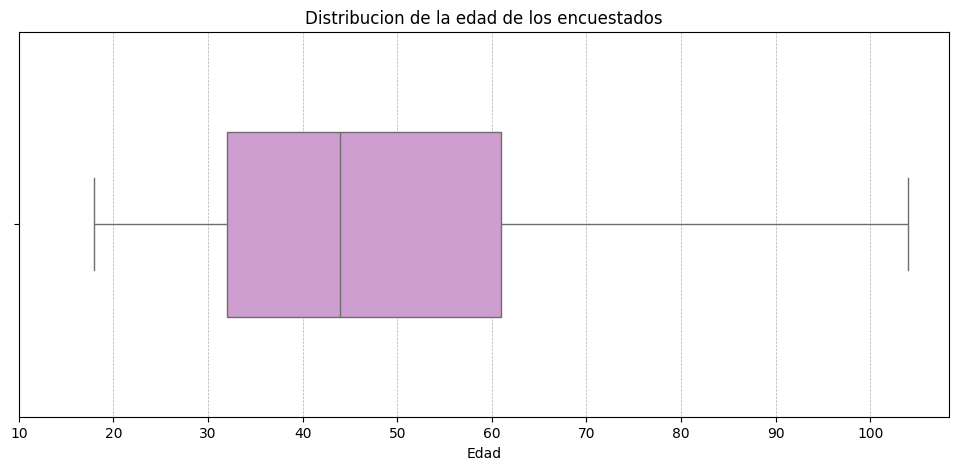

In [ ]:
# Grafico la distribucion de edades de los encuestados
x_edades = [10,20,30,40,50,60,70,80,90,100]
plt.figure(figsize=(12, 5))
sns.boxplot(x=bdfriesgo['edad'], gap=0.4, color='#d695d9')
plt.title('Distribucion de la edad de los encuestados')
plt.xlabel('Edad')
plt.xticks(ticks=x_edades, labels=x_edades)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
plt.show()

En el grafico de boxplot de la distribucion de las edades, puede observarse que:
+ la media de los encuestados esta cercana a los 45 años
+ el dato minimo corresponde a los 18 años 
+ la distribucion de las edades es asimetrica, ya que la media no se encuentra exactamente en el centro de la caja
+Para encontrar esta informacion de manera mas puntual, puedo usar la funcion .describe()

In [ ]:
# Veo la descripcion estadistica de la bd
caract_encuest.edad.describe()

In [ ]:
# Busco los mayores de 40 , que han fumado mas de 100 cigarrillos, por provincia 
mas40fumador = bdfriesgo[(bdfriesgo['edad'] >= 40) & (bdfriesgo['fumado_100_cigarrillos'] == 1)]
# agrupamos por provincia y sexo y contamos las id
mas40fumador_agrupado = mas40fumador.groupby(['cod_provincia', 'sexo']).size().reset_index(name='count')
# cambio los codigos por los nombres de las provincias
mas40fumador_agrupado['cod_provincia'] = mas40fumador_agrupado['cod_provincia'].map(cod_provincia)
# cambio los codigos de los sexos 
mas40fumador_agrupado['sexo'] = mas40fumador_agrupado['sexo'].map(sexo)
# pivoteamos la tabla
pivot_tabla = mas40fumador_agrupado.pivot_table(index='cod_provincia', columns='sexo', values='count', fill_value=0)

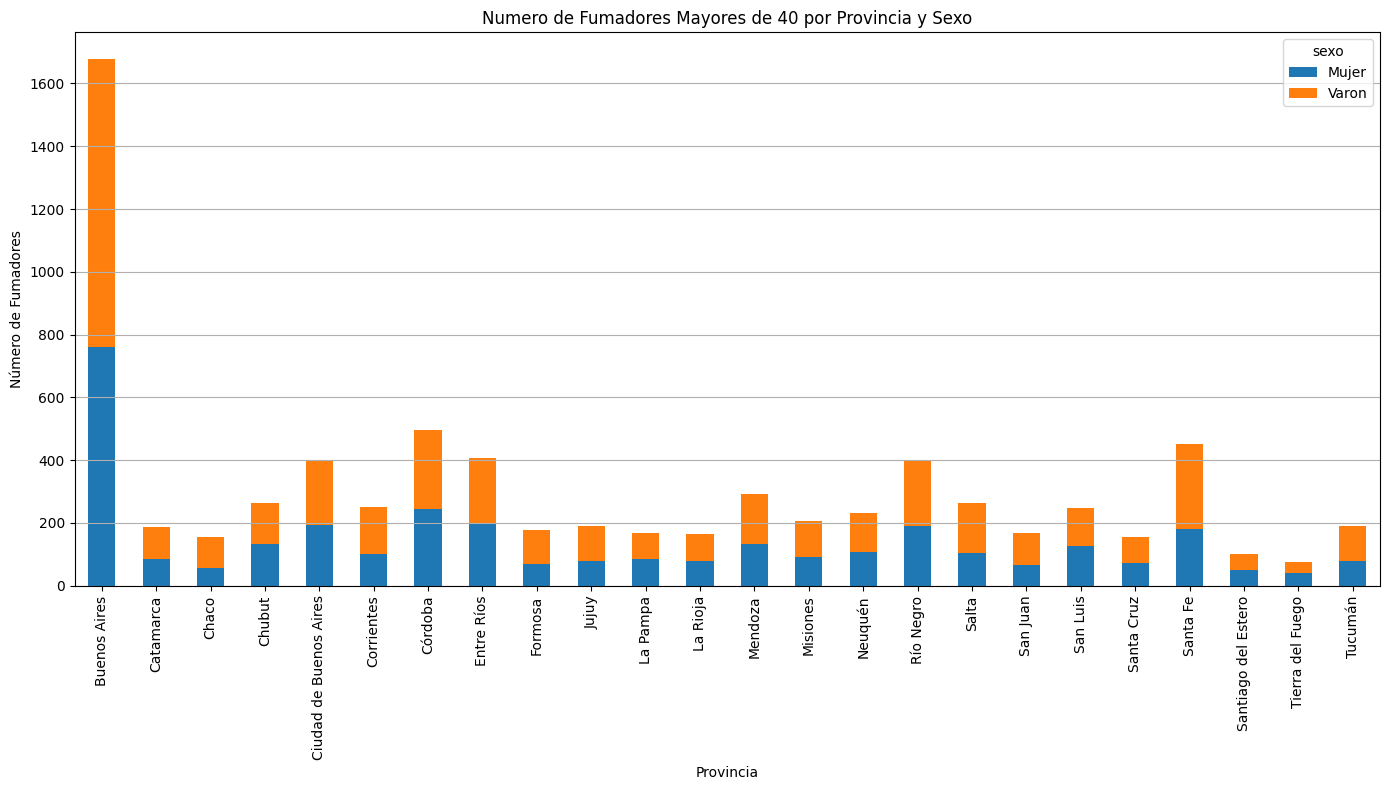

In [ ]:
# Graficamos
pivot_tabla.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Numero de Fumadores Mayores de 40 por Provincia y Sexo')
plt.xlabel('Provincia')
plt.ylabel('Número de Fumadores')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

En la tabla superior 'Numero de Fumadores Mayores de 40 por Provincia y Sexo', puede observarse que en la mayoria de las provincias los fumadores tienden a ser mayormente hombres. Para poder comparar en que provincia es mayor la proporcion de fumadores, debo tener en cuenta la cantidad de encuestados no fumadores.

#### Análisis de variables - Tabaquismo

In [ ]:
tabaquismo.columns

Index(['id', 'es_fumador', 'edad_fuma_primera_vez',
       'edad_fuma_primera_vez_ns_nc', 'fumado_100_cigarrillos',
       'periodicidad_fumador', 'es_cigarrillo_armado', 'es_cigarrillo_paquete',
       'marca_cigarrillos', 'tipo_paquete_comprado',
       'cant_cigarrillos_comprados', 'cant_cigarrillos_comprados_ns_nc',
       'cigarrillos_sabor', 'cigarrillos_tipo_capsula',
       'dinero_pagado_ultima_compra_cigarrillos',
       'dinero_pagado_ultima_compra_cigarrillos_ns_nc', 'intento_dejar_fumar',
       'es_fumador_cigarro_habano', 'es_fumador_cigarritos',
       'es_fumador_pipa_comun', 'es_fumador_pipa_agua',
       'es_fumador_tabaco_masticar', 'es_fumador_cigarrillo_electronico',
       'hubo_fumadores_casa', 'hubo_fumadores_trabajo',
       'hubo_fumadores_escuela', 'hubo_fumadores_restaurant',
       'hubo_fumadores_hospital', 'hubo_fumadores_otros_lugares',
       'publicidad_comercios', 'publicidad_email', 'suscripcion_cigarrera',
       'vio_propaganda_riesgo_fumar', 'pro

##### Edad en la que fumo por primera vez

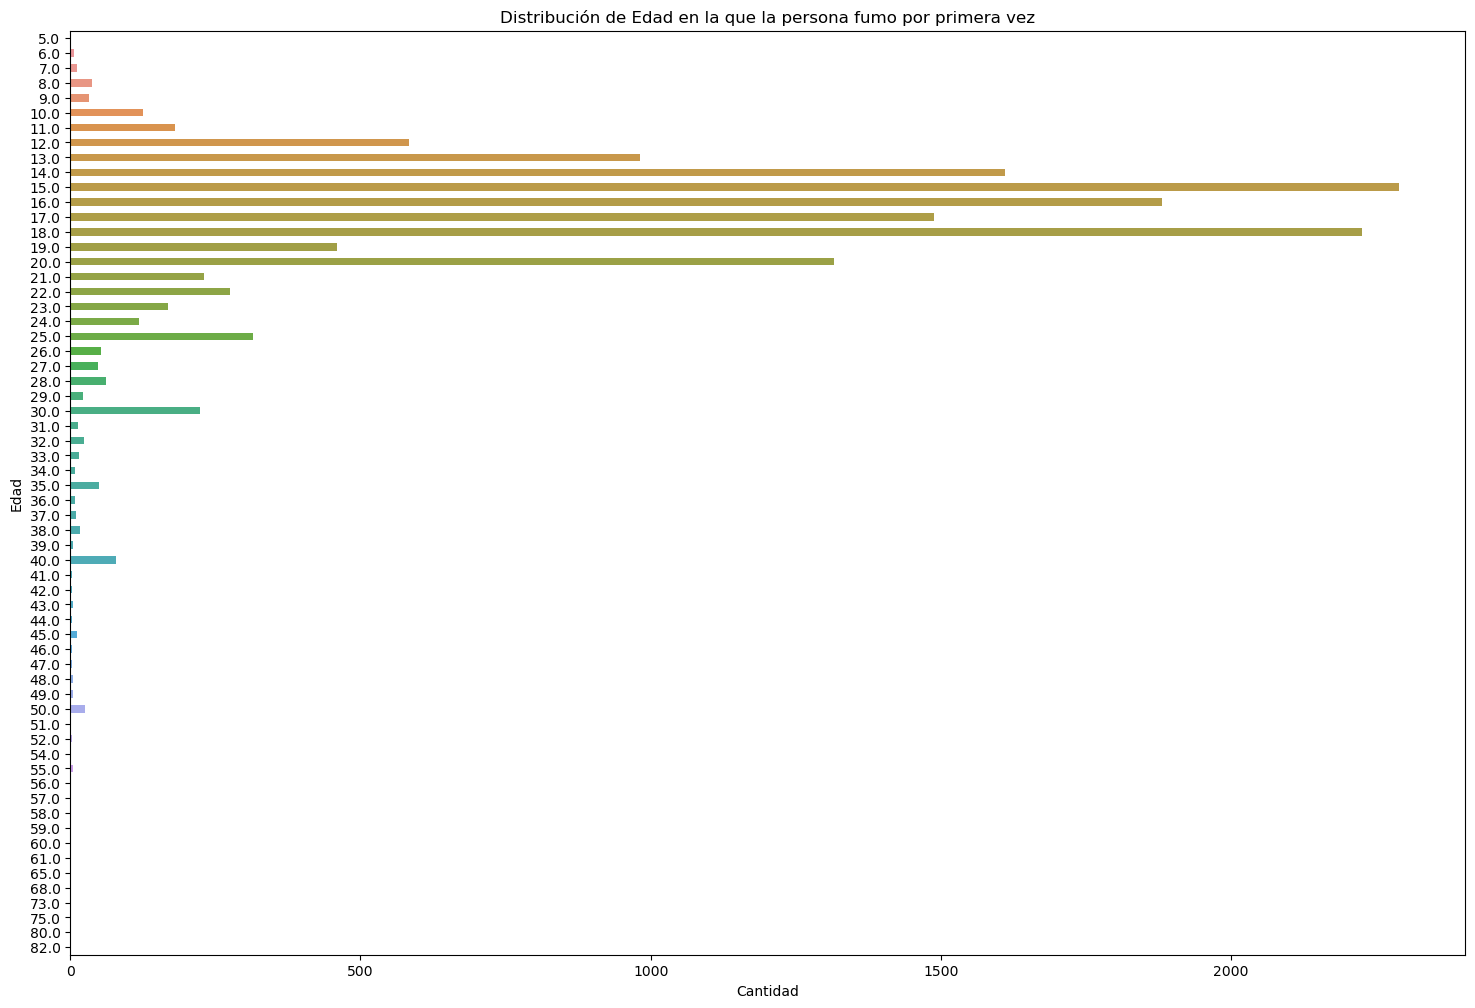

In [ ]:
# Edad en la que fumo por primera vez - Variable numerica discreta

# Configurar el tamaño de la figura
plt.figure(figsize=(18, 12))


sns.countplot(y=tabaquismo['edad_fuma_primera_vez'], width=0.5)
plt.title('Distribución de Edad en la que la persona fumo por primera vez')
plt.xlabel('Cantidad')
plt.ylabel('Edad')
plt.show()

Independientemente del sexo de la persona, la gran mayoria de las personas fuman su primer cigarrillo siendo menores de edad.
Profundicemos...

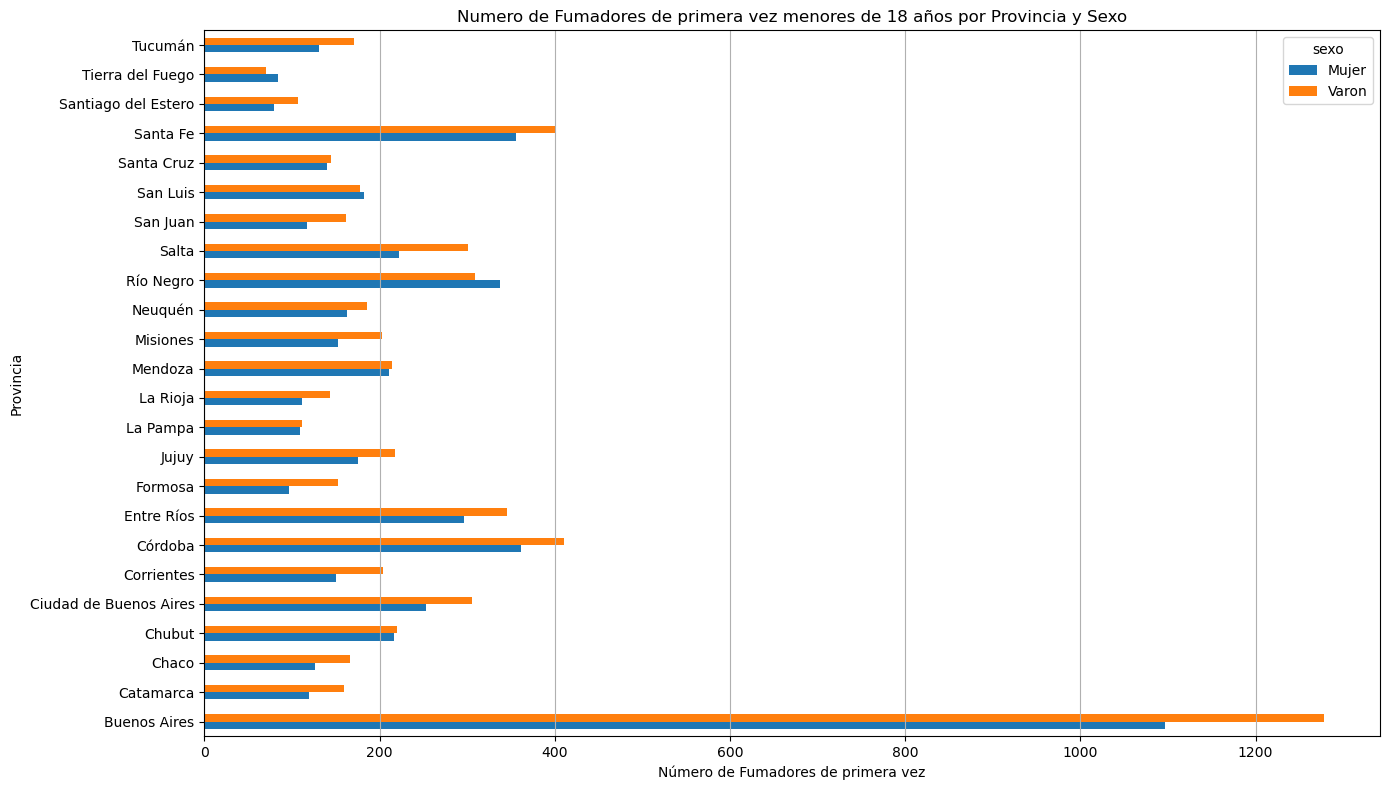

In [ ]:
# Agrupo los menores de edad (18)
menor18fumador_primera_vez = bdfriesgo[(bdfriesgo['edad_fuma_primera_vez'] <= 18)]

# agrupamos por provincia y sexo y contamos los id
menor18fumador_primera_vez_agrupado = menor18fumador_primera_vez.groupby(['cod_provincia', 'sexo']).size().reset_index(name='count')

# reemplazamos los codigos en las tablas por sus valores en el diccionario de codificaciones
menor18fumador_primera_vez_agrupado['sexo'] = menor18fumador_primera_vez_agrupado['sexo'].replace(sexo)
menor18fumador_primera_vez_agrupado['cod_provincia'] = menor18fumador_primera_vez_agrupado['cod_provincia'].replace(cod_provincia)

# pivoteamos la tabla
menor18fumador_primera_vez_agrupado_pt = menor18fumador_primera_vez_agrupado.pivot_table(index='cod_provincia', columns='sexo', values='count', fill_value=0)

# Graficamos
menor18fumador_primera_vez_agrupado_pt.plot(kind='barh', figsize=(14, 8))
plt.title('Numero de Fumadores de primera vez menores de 18 años por Provincia y Sexo')
plt.xlabel('Número de Fumadores de primera vez')
plt.ylabel('Provincia')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Las grandes provincias tienen una mayor proporcion de fumadores menores de edad, que puede tener relacion con la densidad de población en cada una, siendo Buenos Aires, Cordoba y Santa Fe las provincias con mayor cantidad de casos.

Tambien podemos observar que, en la mayoria de las provincias, la proporcion de hombres fumadores por primera vez menores de edad es mayor a la proporcion de mujeres en la misma condicion.

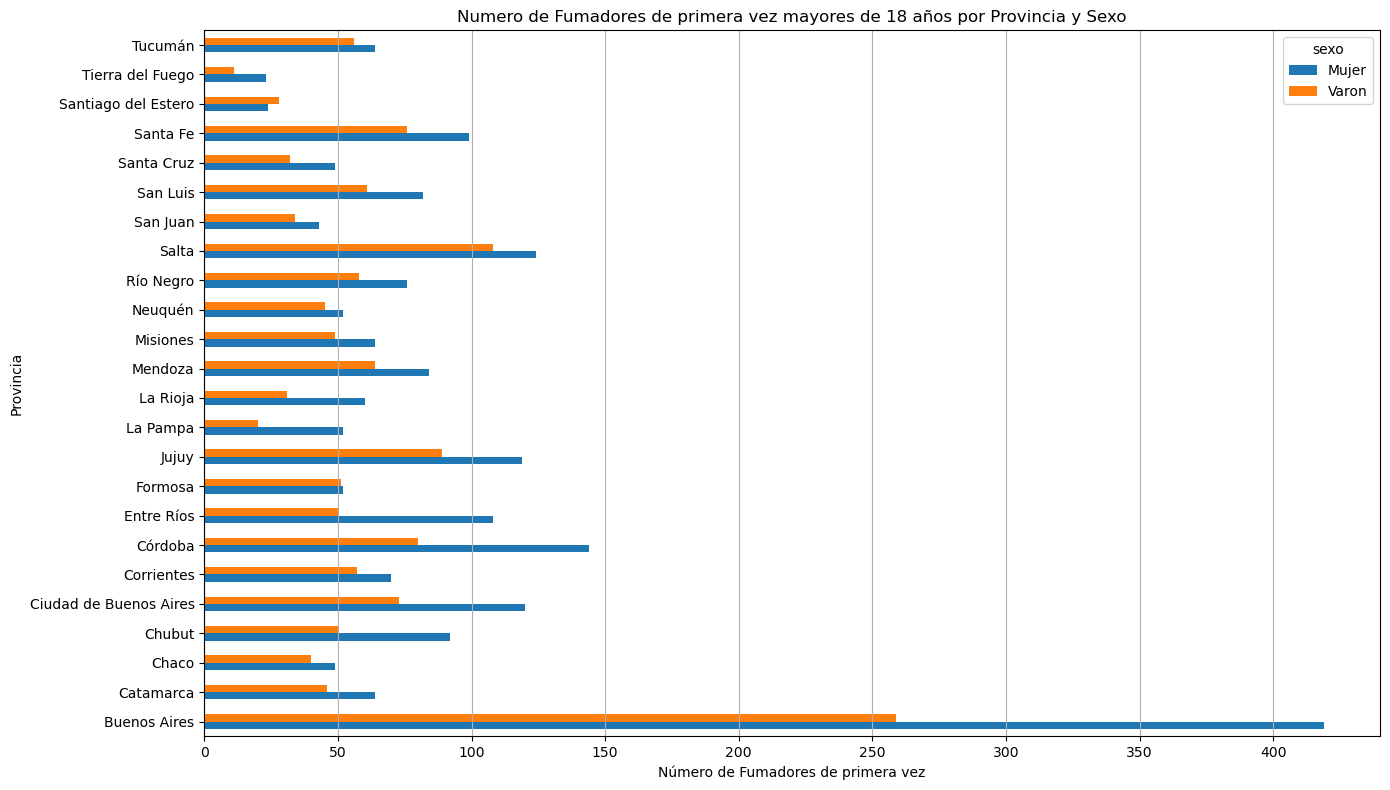

In [ ]:
# Agrupo los mayores de edad (18)
mayor18fumador_primera_vez = bdfriesgo[(bdfriesgo['edad_fuma_primera_vez'] > 18)]

# agrupamos por provincia y sexo y contamos los id
mayor18fumador_primera_vez_agrupado = mayor18fumador_primera_vez.groupby(['cod_provincia', 'sexo']).size().reset_index(name='count')

# reemplazamos los codigos en las tablas por sus valores en el diccionario de codificaciones
mayor18fumador_primera_vez_agrupado['sexo'] = mayor18fumador_primera_vez_agrupado['sexo'].replace(sexo)
mayor18fumador_primera_vez_agrupado['cod_provincia'] = mayor18fumador_primera_vez_agrupado['cod_provincia'].replace(cod_provincia)

# pivoteamos la tabla
mayor18fumador_primera_vez_agrupado_pt = mayor18fumador_primera_vez_agrupado.pivot_table(index='cod_provincia', columns='sexo', values='count', fill_value=0)

# Graficamos
mayor18fumador_primera_vez_agrupado_pt.plot(kind='barh', figsize=(14, 8))
plt.title('Numero de Fumadores de primera vez mayores de 18 años por Provincia y Sexo')
plt.xlabel('Número de Fumadores de primera vez')
plt.ylabel('Provincia')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Las grandes provincias tienen una mayor proporcion de fumadores mayores de edad, que puede tener relacion con la densidad de población en cada una, siendo Buenos Aires y Cordoba las provincias con mayor cantidad de casos, Salta sube a la tercera posicion en este caso.

Tambien podemos observar que, en la mayoria de las provincias, la proporcion de mujeres fumadores por primera vez mayores de edad es mayor a la proporcion de hombres en la misma condicion.

###### Consideracion final del analisis

- La densidad de población puede influir en la cantidad de fumadores de primera vez contabilizados en la encuesta.
- Tanto para menores como para mayores de edad, las 2 ciudades con más incidencias son Buenos Aires y Córdoba.
- La mayoria de la población que comenzó a fumar, lo hizo cuando era menor de edad.
- Distinguiendo por sexo, los hombres son mas propensos a comenzar a fumar siendo menores de edad, mientras que las mujeres son mas propensas a hacerlo siendo mayores de edad.